<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-data" data-toc-modified-id="load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#read-in-the-files" data-toc-modified-id="read-in-the-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read in the files</a></span><ul class="toc-item"><li><span><a href="#data-from-linear-and-relu-activations" data-toc-modified-id="data-from-linear-and-relu-activations-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>data from linear and relu activations</a></span></li></ul></li><li><span><a href="#create-pandas-table" data-toc-modified-id="create-pandas-table-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>create pandas table</a></span></li></ul></li><li><span><a href="#filter-out-bad-training-losses" data-toc-modified-id="filter-out-bad-training-losses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>filter out bad training losses</a></span></li><li><span><a href="#determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)" data-toc-modified-id="determine-the-lambda-parameter-that-gets-the-best-test-MSE-for-each-(r,n,L)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>determine the lambda parameter that gets the best test MSE for each (r,n,L)</a></span></li><li><span><a href="#Generalization-MSE" data-toc-modified-id="Generalization-MSE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Generalization MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Out-of-Distribution-MSE" data-toc-modified-id="Out-of-Distribution-MSE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Out of Distribution MSE</a></span><ul class="toc-item"><li><span><a href="#generate-data" data-toc-modified-id="generate-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>generate data</a></span></li><li><span><a href="#compute-MSE" data-toc-modified-id="compute-MSE-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>compute MSE</a></span></li></ul></li><li><span><a href="#Active-Subspace" data-toc-modified-id="Active-Subspace-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Active Subspace</a></span><ul class="toc-item"><li><span><a href="#evaluate-gradients-and-compute-singular-values-and-active-subspaces" data-toc-modified-id="evaluate-gradients-and-compute-singular-values-and-active-subspaces-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>evaluate gradients and compute singular values and active subspaces</a></span></li><li><span><a href="#plot-of-singular-values" data-toc-modified-id="plot-of-singular-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>plot of singular values</a></span></li></ul></li><li><span><a href="#determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)" data-toc-modified-id="determine-the-L-parameter-that-gets-the-best-test-MSE-for-each-(r,n)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>determine the L parameter that gets the best test MSE for each (r,n)</a></span></li><li><span><a href="#Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers" data-toc-modified-id="Plots-of-L-vs-Test-error-and-n-vs-Generalization-metrics-with/without-linear-layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots of L vs Test error and n vs Generalization metrics with/without linear layers</a></span></li><li><span><a href="#Final-Table" data-toc-modified-id="Final-Table-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Final Table</a></span></li><li><span><a href="#Training-Time-Plots" data-toc-modified-id="Training-Time-Plots-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Training Time Plots</a></span><ul class="toc-item"><li><span><a href="#Train-MSE-v-Epoch" data-toc-modified-id="Train-MSE-v-Epoch-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Train MSE v Epoch</a></span></li><li><span><a href="#Weight-Decay-v-Epoch" data-toc-modified-id="Weight-Decay-v-Epoch-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Weight Decay v Epoch</a></span></li><li><span><a href="#learning-rates" data-toc-modified-id="learning-rates-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>learning rates</a></span></li></ul></li></ul></div>

# imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import ortho_group
from scipy.stats import linregress
from scipy import linalg as la
from torch import nn
import torch
import os

# load data

## read in the files

In [3]:
rnvals = [(1,64),(1,128),(1,256),(1,512),(1,1024),(1,2048),
          (2,64),(2,128),(2,256),(2,512),(2,1024),(2,2048)]
Ls = [2,3,4,5,6,7,8,9]
wds = [1e-3,1e-4,1e-5]
epochs = 60100
job_name = "GPUmanylayers"

### data from linear and relu activations

In [4]:
testMSEs = {}
trainMSEs = {}
weightdecays = {}
learningrates = {}
files_found_list = []
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            paramname = job_name+f"/N{n}_L{L}_r{r}_wd{wd}_epochs{epochs}"
            if os.path.exists(paramname+"testMSE.npy"):
                testMSEs[r,n,L,wd] = np.load(paramname+"testMSE.npy",allow_pickle=True).item()
                trainMSEs[r,n,L,wd] = np.load(paramname+"trainMSEs.npy",allow_pickle=True)
                weightdecays[r,n,L,wd] = np.load(paramname+"weightdecays.npy",allow_pickle=True)
                learningrates[r,n,L,wd] = np.load(paramname+"learningrates.npy",allow_pickle=True)
                files_found_list.append((r,n,L,wd))
            else:
                print(f"{paramname+'testMSE.npy'} not found")

In [5]:
files_found_list

[(1, 64, 2, 0.001),
 (1, 64, 2, 0.0001),
 (1, 64, 2, 1e-05),
 (1, 64, 3, 0.001),
 (1, 64, 3, 0.0001),
 (1, 64, 3, 1e-05),
 (1, 64, 4, 0.001),
 (1, 64, 4, 0.0001),
 (1, 64, 4, 1e-05),
 (1, 64, 5, 0.001),
 (1, 64, 5, 0.0001),
 (1, 64, 5, 1e-05),
 (1, 64, 6, 0.001),
 (1, 64, 6, 0.0001),
 (1, 64, 6, 1e-05),
 (1, 64, 7, 0.001),
 (1, 64, 7, 0.0001),
 (1, 64, 7, 1e-05),
 (1, 64, 8, 0.001),
 (1, 64, 8, 0.0001),
 (1, 64, 8, 1e-05),
 (1, 64, 9, 0.001),
 (1, 64, 9, 0.0001),
 (1, 64, 9, 1e-05),
 (1, 128, 2, 0.001),
 (1, 128, 2, 0.0001),
 (1, 128, 2, 1e-05),
 (1, 128, 3, 0.001),
 (1, 128, 3, 0.0001),
 (1, 128, 3, 1e-05),
 (1, 128, 4, 0.001),
 (1, 128, 4, 0.0001),
 (1, 128, 4, 1e-05),
 (1, 128, 5, 0.001),
 (1, 128, 5, 0.0001),
 (1, 128, 5, 1e-05),
 (1, 128, 6, 0.001),
 (1, 128, 6, 0.0001),
 (1, 128, 6, 1e-05),
 (1, 128, 7, 0.001),
 (1, 128, 7, 0.0001),
 (1, 128, 7, 1e-05),
 (1, 128, 8, 0.001),
 (1, 128, 8, 0.0001),
 (1, 128, 8, 1e-05),
 (1, 128, 9, 0.001),
 (1, 128, 9, 0.0001),
 (1, 128, 9, 1e-05),


In [6]:
def Llayers(L,d=20,width=1000):
    #construct L-1 linear layers; bias term only on last linear layer
    if L < 2:
        raise ValueError("L must be at least 2")
    if L == 2:
        linear_layers = [nn.Linear(d,width,bias=True)]
    if L > 2:
        linear_layers = [nn.Linear(d,width,bias=False)]
        for l in range(L-3):
            linear_layers.append(nn.Linear(width,width,bias=False))
        linear_layers.append(nn.Linear(width,width,bias=True))

    relu = nn.ReLU()

    last_layer = nn.Linear(width,1)

    layers = linear_layers + [relu,last_layer]

    return nn.Sequential(*layers)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
files_found_list = []
models = {}
for r,n in rnvals:
    for L in Ls:
        for wd in wds:
            paramname = job_name+f"/N{n}_L{L}_r{r}_wd{wd}_epochs60100"#f"r{r}_N{n}"
            if os.path.exists(paramname+"model.pt"):
                models[r,n,L,wd] = Llayers(L,width=1000)
                models[r,n,L,wd].to(device)
                if torch.cuda.is_available():
                    models[r,n,L,wd].load_state_dict(torch.load(paramname+"model.pt"))
                else:
                    models[r,n,L,wd].load_state_dict(torch.load(paramname+"model.pt"),map_location=torch.device('cpu'))
                models[r,n,L,wd].eval()
                files_found_list.append((r,n,L,wd))
            else:
                print(paramname+"model.pt","not found")

In [9]:
files_found_list

[(1, 64, 2, 0.001),
 (1, 64, 2, 0.0001),
 (1, 64, 2, 1e-05),
 (1, 64, 3, 0.001),
 (1, 64, 3, 0.0001),
 (1, 64, 3, 1e-05),
 (1, 64, 4, 0.001),
 (1, 64, 4, 0.0001),
 (1, 64, 4, 1e-05),
 (1, 64, 5, 0.001),
 (1, 64, 5, 0.0001),
 (1, 64, 5, 1e-05),
 (1, 64, 6, 0.001),
 (1, 64, 6, 0.0001),
 (1, 64, 6, 1e-05),
 (1, 64, 7, 0.001),
 (1, 64, 7, 0.0001),
 (1, 64, 7, 1e-05),
 (1, 64, 8, 0.001),
 (1, 64, 8, 0.0001),
 (1, 64, 8, 1e-05),
 (1, 64, 9, 0.001),
 (1, 64, 9, 0.0001),
 (1, 64, 9, 1e-05),
 (1, 128, 2, 0.001),
 (1, 128, 2, 0.0001),
 (1, 128, 2, 1e-05),
 (1, 128, 3, 0.001),
 (1, 128, 3, 0.0001),
 (1, 128, 3, 1e-05),
 (1, 128, 4, 0.001),
 (1, 128, 4, 0.0001),
 (1, 128, 4, 1e-05),
 (1, 128, 5, 0.001),
 (1, 128, 5, 0.0001),
 (1, 128, 5, 1e-05),
 (1, 128, 6, 0.001),
 (1, 128, 6, 0.0001),
 (1, 128, 6, 1e-05),
 (1, 128, 7, 0.001),
 (1, 128, 7, 0.0001),
 (1, 128, 7, 1e-05),
 (1, 128, 8, 0.001),
 (1, 128, 8, 0.0001),
 (1, 128, 8, 1e-05),
 (1, 128, 9, 0.001),
 (1, 128, 9, 0.0001),
 (1, 128, 9, 1e-05),


## create pandas table

In [10]:
res = {
  "r"                 : [r                         for r,n,L,wd in files_found_list],# + [r                         for wd in wds for r,n in relu_rnvals],
  "n"                 : [n                         for r,n,L,wd in files_found_list],# + [n                         for wd in wds for r,n in relu_rnvals],
  "L"                 : [L                         for r,n,L,wd in files_found_list],# + [4                         for wd in wds for r,n in relu_rnvals],
  "lambda"            : [wd                        for r,n,L,wd in files_found_list],# + [wd                        for wd in wds for r,n in relu_rnvals],
  "Learning Rate"     : [learningrates[r,n,L,wd]   for r,n,L,wd in files_found_list],# + [RELUlearningrates[r,n][4][wd] for wd in wds for r,n in relu_rnvals],
  "Train MSE"         : [trainMSEs[r,n,L,wd]       for r,n,L,wd in files_found_list],# + [RELUtrainMSEs[r,n][4][wd]     for wd in wds for r,n in relu_rnvals],
  "Weight Decay"      : [weightdecays[r,n,L,wd]    for r,n,L,wd in files_found_list],# + [RELUweightdecays[r,n][4][wd]  for wd in wds for r,n in relu_rnvals],
  "Model"             : [models[r,n,L,wd]          for r,n,L,wd in files_found_list],# + [RELUmodels[r,n,4,wd]          for wd in wds for r,n in relu_rnvals],
  "Test MSE"          : [testMSEs[r,n,L,wd]        for r,n,L,wd in files_found_list],# + [RELUtestMSEs[r,n][4][wd].item()      for wd in wds for r,n in relu_rnvals],
  "Activations"       : ["linear and relu"         for r,n,L,wd in files_found_list],# + ["relu only"         for wd in wds for r,n in relu_rnvals]
}
res = pd.DataFrame(res)
res["Final Train MSE"] = [r[-1] for r in res["Train MSE"]]
res["Final Weight Decay"] = [r[-1] for r in res["Weight Decay"]]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.94083, 46.85972, 46.77882, 46.698128, 46.6...","[1340.811, 1340.6844, 1340.561, 1340.4401, 134...","[Linear(in_features=20, out_features=1000, bia...",0.119706,linear and relu,3.649561e-06,228.721588
1,1,64,2,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.94083, 46.859703, 46.7788, 46.698097, 46.6...","[1340.8812, 1340.8269, 1340.7769, 1340.7301, 1...","[Linear(in_features=20, out_features=1000, bia...",0.176121,linear and relu,3.919119e-09,230.157959
2,1,64,2,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.940826, 46.859707, 46.7788, 46.698097, 46....","[1340.8917, 1340.8499, 1340.8105, 1340.7739, 1...","[Linear(in_features=20, out_features=1000, bia...",0.697939,linear and relu,2.046273e-12,249.742188
3,1,64,3,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.71048, 46.291706, 45.88084, 45.47898, 45.0...","[3341.586, 3341.4255, 3341.3818, 3341.4531, 33...","[Linear(in_features=20, out_features=1000, bia...",0.015205,linear and relu,1.265198e-04,151.614090
4,1,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.710453, 46.291626, 45.88073, 45.478848, 45...","[3341.833, 3341.9233, 3342.1328, 3342.459, 334...","[Linear(in_features=20, out_features=1000, bia...",0.012496,linear and relu,1.132934e-06,178.268677
...,...,...,...,...,...,...,...,...,...,...,...,...
283,2,2048,8,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.562706, 39.381737, 17.358593, 10.517123, 9...","[23523.12, 23560.178, 23668.205, 23642.596, 23...","[Linear(in_features=20, out_features=1000, bia...",0.000101,linear and relu,1.692415e-05,521.803589
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.5625, 39.316772, 17.49003, 10.495918, 9.45...","[23546.506, 23585.86, 23694.807, 23670.02, 236...","[Linear(in_features=20, out_features=1000, bia...",0.000095,linear and relu,1.435368e-05,720.301086
285,2,2048,9,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.673347, 27.75809, 15.627261, 14.277113, 11...","[29144.451, 29154.033, 29159.953, 29155.61, 29...","[Linear(in_features=20, out_features=1000, bia...",0.000199,linear and relu,6.726003e-05,556.805176
286,2,2048,9,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.416122, 27.804901, 15.694317, 14.074917, 1...","[29420.867, 29445.838, 29472.56, 29491.002, 29...","[Linear(in_features=20, out_features=1000, bia...",0.000102,linear and relu,1.144927e-05,567.734436


# filter out bad training losses

In [ ]:
res[res["Final Train MSE"] >= 1e-2]

In [ ]:
res = res[res["Final Train MSE"] < 1e-2]
res

#  determine the lambda parameter that gets the best test MSE for each (r,n,L)

In [11]:
testmse_vs_lambda = res.pivot_table(values="Test MSE",index = ("r","n","L","Activations"),columns=["lambda"])
testmse_vs_lambda

lambda                     0.00001   0.00010   0.00100
r n    L Activations                                  
1 64   2 linear and relu  0.697939  0.176121  0.119706
       3 linear and relu  0.324526  0.012496  0.015205
       4 linear and relu  0.055462  0.018579  0.000995
       5 linear and relu  0.067298  0.028189  0.000695
       6 linear and relu  0.073758  0.033879  0.000725
...                            ...       ...       ...
2 2048 5 linear and relu  0.000092  0.000106  0.000411
       6 linear and relu  0.000092  0.000098  0.000284
       7 linear and relu  0.000098  0.000099  0.000233
       8 linear and relu  0.000095  0.000101  0.000199
       9 linear and relu  0.000100  0.000102  0.000199

[96 rows x 3 columns]

In [12]:
bestlambda = testmse_vs_lambda.idxmin(axis=1)
bestlambda

r  n     L  Activations    
1  64    2  linear and relu    0.00100
         3  linear and relu    0.00010
         4  linear and relu    0.00100
         5  linear and relu    0.00100
         6  linear and relu    0.00100
                                ...   
2  2048  5  linear and relu    0.00001
         6  linear and relu    0.00001
         7  linear and relu    0.00001
         8  linear and relu    0.00001
         9  linear and relu    0.00001
Length: 96, dtype: float64

In [13]:
mask = [row["lambda"] == bestlambda[row["r"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,n,L,lambda,Learning Rate,Train MSE,Weight Decay,Model,Test MSE,Activations,Final Train MSE,Final Weight Decay
0,1,64,2,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.94083, 46.85972, 46.77882, 46.698128, 46.6...","[1340.811, 1340.6844, 1340.561, 1340.4401, 134...","[Linear(in_features=20, out_features=1000, bia...",0.119706,linear and relu,0.000004,228.721588
4,1,64,3,0.00010,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.710453, 46.291626, 45.88073, 45.478848, 45...","[3341.833, 3341.9233, 3342.1328, 3342.459, 334...","[Linear(in_features=20, out_features=1000, bia...",0.012496,linear and relu,0.000001,178.268677
6,1,64,4,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.590126, 46.100685, 45.620777, 45.14263, 44...","[6009.557, 6009.319, 6009.3955, 6009.7773, 601...","[Linear(in_features=20, out_features=1000, bia...",0.000995,linear and relu,0.000058,147.673447
9,1,64,5,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.45391, 46.070526, 45.691345, 45.296654, 44...","[9342.156, 9341.23, 9340.908, 9341.171, 9341.9...","[Linear(in_features=20, out_features=1000, bia...",0.000695,linear and relu,0.000077,151.917374
12,1,64,6,0.00100,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.611046, 46.307167, 45.982555, 45.605865, 4...","[13338.912, 13335.697, 13333.5625, 13332.438, ...","[Linear(in_features=20, out_features=1000, bia...",0.000725,linear and relu,0.000082,166.722778
...,...,...,...,...,...,...,...,...,...,...,...,...
275,2,2048,5,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[79.03601, 14.673456, 7.1955748, 6.301117, 5.8...","[9526.033, 9935.584, 9980.475, 10001.476, 1001...","[Linear(in_features=20, out_features=1000, bia...",0.000092,linear and relu,0.000011,597.575500
278,2,2048,6,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[48.78592, 11.064767, 8.407269, 7.039444, 6.65...","[13612.924, 13812.055, 13849.014, 13880.938, 1...","[Linear(in_features=20, out_features=1000, bia...",0.000092,linear and relu,0.000008,581.571960
281,2,2048,7,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[37.673447, 11.727802, 8.1880665, 7.1784163, 6...","[18368.146, 18397.58, 18442.668, 18463.33, 184...","[Linear(in_features=20, out_features=1000, bia...",0.000098,linear and relu,0.000011,625.433533
284,2,2048,8,0.00001,"[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...","[46.5625, 39.316772, 17.49003, 10.495918, 9.45...","[23546.506, 23585.86, 23694.807, 23670.02, 236...","[Linear(in_features=20, out_features=1000, bia...",0.000095,linear and relu,0.000014,720.301086


# Generalization MSE

## generate data

In [5]:
def gen_data(datasetsize,r,seed,trainsize=2**18,testsize=2**10,d=20,funcseed=42,verbose=False,ood=False,std=0):
    ##Generate data with a true central subspaces of varying dimensions
    #generate X values for training and test sets
    np.random.seed(seed) #set seed for data generation
    trainX = np.random.rand(d,trainsize).astype(np.float32)[:,:datasetsize] - 0.5 #distributed as U[-1/2, 1/2]
    testX = np.random.rand(d,testsize).astype(np.float32) - 0.5 #distributed as U[-1/2, 1/2]
    #out of distribution datagen
    if ood:
        trainX *= 2 #now distributed as U[-1, 1]
        testX *= 2 #now distributed as U[-1, 1]
    ##for each $r$ value create and store data-gen functions and $y$ evaluations
    #geneate params for functions
    k = d+1
    U = np.load(job_name+f"/r{r}U.npy")
    Sigma = np.load(job_name+f"/r{r}Sigma.npy")
    V = np.load(job_name+f"/r{r}V.npy")
    A = np.load(job_name+f"/r{r}A.npy")
    B = np.load(job_name+f"/r{r}B.npy")
    #create functions
    def g(z): #active subspace function
        hidden_layer = (U*Sigma)@z
        hidden_layer = hidden_layer.T + B
        hidden_layer = np.maximum(0,hidden_layer).T
        return A@hidden_layer
    def f(x): #teacher network
        z = V.T@x
        eps = torch.normal(mean=torch.zeros(num_pnts),std=std*torch.ones(num_pnts)).to(device)
        return g(z) + eps
    #generate data
    trainY = f(trainX).astype(np.float32)
    testY = f(testX).astype(np.float32)
    #move data to device
    if verbose:
        print("device: {}".format(device))
    trainX = torch.from_numpy(trainX).T.to(device)
    trainY = torch.from_numpy(trainY).to(device)
    testX = torch.from_numpy(testX).T.to(device)
    testY = torch.from_numpy(testY).to(device)
    if verbose:
        print("trainX shape = {} trainY shape = {}".format(
            trainX.shape,
            trainY.shape
        ))
    return trainX,trainY,testX,testY


In [6]:
generalizationX,generalizationYr1 = gen_data(2048,r=1,seed=101)[:2]
generalizationX,generalizationYr2 = gen_data(2048,r=2,seed=101)[:2]
generalizationY = {1:generalizationYr1,2:generalizationYr2}

torch.Size([2048]) tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
torch.Size([2048]) tensor([ 1.5574,  7.7949, 19.1428,  ...,  8.1604, 10.2077,  3.3550],
       device='cuda:0', grad_fn=<AddBackward0>)


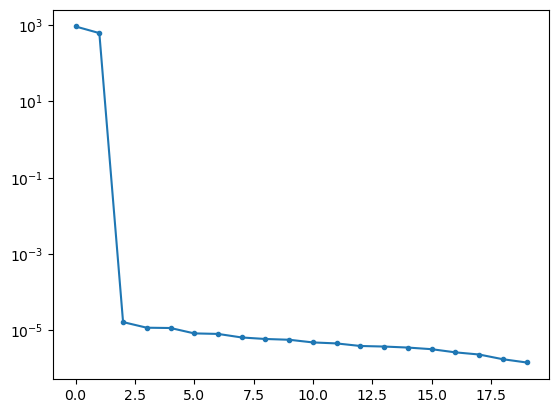

In [27]:
#evaluate gradients
r = 2
std = 0
U = torch.from_numpy(np.load(job_name+f"/r{r}U.npy").astype(np.float32)).to(device)
Sigma =  torch.from_numpy(np.load(job_name+f"/r{r}Sigma.npy").astype(np.float32)).to(device)
V =  torch.from_numpy(np.load(job_name+f"/r{r}V.npy").astype(np.float32)).to(device)
A =  torch.from_numpy(np.load(job_name+f"/r{r}A.npy").astype(np.float32)).to(device)
B =  torch.from_numpy(np.load(job_name+f"/r{r}B.npy").astype(np.float32)).to(device)
def g(z): #active subspace function
    hidden_layer = (U*Sigma)@z
    hidden_layer = hidden_layer.T + B
    hidden_layer = torch.maximum(torch.zeros_like(hidden_layer),hidden_layer).T
    return A@hidden_layer
def f(x): #teacher network
    z = V.T@x
    num_pnts = x.shape[1]
    eps = torch.normal(mean=torch.zeros(num_pnts),std=std*torch.ones(num_pnts)).to(device)
    print(eps.shape,eps)
    print((g(z) + eps).shape,g(z) + eps)
    return g(z) + eps
generalizationX.requires_grad = True
predY = f(generalizationX.T)
grad = torch.autograd.grad(predY, generalizationX,
                        grad_outputs=torch.ones_like(predY),
                        create_graph=True)[0].detach().cpu().numpy()
#compute active subspace and singular values
Uhat,Shat,VhatT = np.linalg.svd(grad)
plt.semilogy(Shat,".-")

In [ ]:
print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))

In [8]:
generalizationX.min(),generalizationX.max()

(tensor(-0.4999), tensor(0.5000))

## compute MSE

In [ ]:
with torch.no_grad():
    generalization = []
    for rownum, row in res.iterrows():
        predY = row["Model"](generalizationX)
        err = nn.functional.mse_loss(predY[:,0],generalizationY[row["r"]]).item()
        generalization.append(err)
    res["Generalization MSE"] = generalization

In [ ]:
res

# Out of Distribution MSE

## generate data

In [ ]:
oodX,oodYr1 = gen_data(2048,r=1,seed=101,ood=True)[:2] #generate out of distribution data
oodX,oodYr2 = gen_data(2048,r=2,seed=101,ood=True)[:2]
oodY = {1:oodYr1,2:oodYr2}

In [ ]:
oodX.min(),oodX.max()

## compute MSE

In [ ]:
with torch.no_grad():
    ood_errs = []
    for rownum, row in res.iterrows():
        predY = row["Model"](oodX)
        err = nn.functional.mse_loss(predY[:,0],oodY[row["r"]]).item()
        ood_errs.append(err)
    res["Out of Distribution MSE"] = ood_errs

In [ ]:
res

# Active Subspace

## evaluate gradients and compute singular values and active subspaces

In [ ]:
generalizationY

In [ ]:
grads = []
sv = []
active_subspace = []
subspace_dist = []

for rownum, row in res.iterrows():
    #compute ground truth active subspace
    funcseed = 42
    d = 20
    k = d+1
    U = np.load(job_name+f"/r{row['r']}U.npy")
    Sigma = np.load(job_name+f"/r{row['r']}Sigma.npy")
    V = np.load(job_name+f"/r{row['r']}V.npy")
    W = np.load(job_name+f"/r{row['r']}W.npy")
    A = np.load(job_name+f"/r{row['r']}A.npy")
    B = np.load(job_name+f"/r{row['r']}B.npy")

    #evaluate gradients
    generalizationX.requires_grad = True
    predY = row["Model"](generalizationX)
    grad = torch.autograd.grad(predY, generalizationX,
                            grad_outputs=torch.ones_like(predY),
                            create_graph=True)[0].detach().cpu().numpy()
    grads.append(grad)
    #compute active subspace and singular values
    Uhat,Shat,VhatT = np.linalg.svd(grad)
    Vhat = VhatT.T[:,:row["r"]] #form the basis for the active subspace
    active_subspace.append(Vhat)
    sv.append(Shat)

    subspace_dist.append(np.linalg.norm(V@V.T - Vhat@Vhat.T,2))

res["Gradient Evaluations"] = grads
res["Gradient Singular Values"] = sv
res["Active Subspace"] = active_subspace
res["Active Subspace Distance"] = subspace_dist
res["Active Subspace Alignment Angle (Degrees)"] = np.degrees(np.arcsin(res["Active Subspace Distance"]))

res

## plot of singular values

In [ ]:
# colors = {(1,64):"tab:blue",(1,2048):"tab:cyan",(2,64):"tab:orange",(2,128):"tab:pink",(2,256):"tab:red",(2,2048):"tab:purple"}

In [ ]:
res.n.unique()

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(10,4.8))#len(res.r.unique()),len(res.n.unique())
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    print(whichrow,whichcol)
    #whichax = row['L'] - 2
#     color = colors[(row['L'])]
    print(rf"{row['r']},{row['n']},{row['L']}",row["Gradient Singular Values"]/np.sqrt(2048),whichrow,whichcol)
    ax[whichrow,whichcol].semilogy(row["Gradient Singular Values"]/np.sqrt(2048),label=rf"$L={row['L']}$",linewidth=1,alpha=0.7,marker=".")
    ax[whichrow,whichcol].set_xticks(list(range(3,20,4)),list(range(4,21,4)))
    ax[whichrow,whichcol].set_ylim(10**-9,10**3)
    ax[0,whichcol].set_title(rf"$n={row['n']}$")
    ax[-1,whichcol].set_xlabel(rf"Index, $k$")
plt.subplot(2,len(res.n.unique()),1)
leg = plt.legend()
leg = plt.legend(bbox_to_anchor=(-1, 1))
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)
plt.subplot(2,len(res.n.unique()),1)
plt.ylabel(r"$r=1$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
plt.yticks([10**p for p in range(-8,3,2)])
plt.subplot(2,len(res.n.unique()),len(res.n.unique())+1)
plt.ylabel(r"$r=2$"+"\n"+r"$\sigma_k(\hat f;\rho)$")
plt.yticks([10**p for p in range(-8,3,2)])
plt.suptitle("Singular Values of Trained Networks")
plt.tight_layout()
plt.savefig(job_name+"/sv.png",dpi=300,bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

#  determine the L parameter that gets the best test MSE for each (r,n)

In [ ]:
testmse_vs_L = res.pivot_table(values="Test MSE",index = ("r","n","Activations"),columns=["L"])
testmse_vs_L = testmse_vs_L.iloc[:,1:]
testmse_vs_L

In [ ]:
bestL = testmse_vs_L.idxmin(axis=1)
bestL

In [ ]:
mask = [row["L"] == bestL[row["r"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]
bestLres

# Plots of L vs Test error and n vs Generalization metrics with/without linear layers

In [ ]:
res.r.unique()

In [ ]:
f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
for rnum,r in enumerate(res.r.unique()):
    for n in res.n.unique():
        res_rn = res[(res.r == r) * (res.n == n)]
        ax[rnum].scatter(res_rn.L,res_rn[["Test MSE"]])
        ax[rnum].semilogy(res_rn.L,res_rn[["Test MSE"]],label=rf"$n={n}$")
    ax[rnum].set_xlabel("$L$ number of layers")
    ax[rnum].set_title(rf"$r={r}$")
ax[0].legend()
ax[0].set_ylabel("Validation MSE")
f.suptitle(rf"Validation MSE for best $\lambda$ values")
f.tight_layout()
f.savefig(job_name+f"/Validation MSE.png",dpi=300)
plt.show()

In [ ]:
for metric in ['Generalization MSE', 'Out of Distribution MSE','Active Subspace Alignment Angle (Degrees)']:
    f, ax = plt.subplots(ncols=len(res.r.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
    for rnum,r in enumerate(res.r.unique()):
        plt.subplot(1,2,r)
        #best L
        curr = bestLres[bestLres.r == r]
        ax[rnum].scatter(curr.n,curr[[metric]])
        ax[rnum].plot(curr.n,curr[[metric]],label=rf"linear layers")
        #no linear layers
        no_lin_layers = res[(res.r == r) * (res.L == 2)]
        ax[rnum].scatter(no_lin_layers.n,no_lin_layers[[metric]])
        ax[rnum].plot(no_lin_layers.n,no_lin_layers[[metric]],label=rf"no linear layers")
        #plotting extras
        ax[rnum].set_xlabel("$n$ number of samples")
        ax[rnum].set_xscale("log",base=2)
        if metric != 'Active Subspace Alignment Angle (Degrees)':
            ax[rnum].set_yscale("log",base=10)
        ax[rnum].set_title(rf"$r={r}$")
    ax[0].set_ylabel(f"{metric}")
    ax[0].legend()
    plt.suptitle(f"{metric}" + r" with best $(\lambda,L)$ tuning")
    plt.tight_layout()
    plt.savefig(job_name+f"/{metric}.png",dpi=300)
    plt.show()

# Final Table

In [ ]:
res.loc[(res.L == 2),"Activations"] = "Shallow ReLU"

In [ ]:
bestLres = pd.concat((res[(res.L == 2)],bestLres))

In [ ]:
bestLres.shape

In [ ]:
pivot_table = bestLres.pivot_table(index=("r","n","Activations"))
print(pivot_table.shape)
pivot_table

In [ ]:
pivot_table.idxmin(axis=0)

In [ ]:
pivot_table_latex = pivot_table.drop(["Final Weight Decay"],axis=1)
pivot_table_latex = pivot_table_latex[["L","lambda","Final Train MSE","Generalization MSE","Out of Distribution MSE","Active Subspace Alignment Angle (Degrees)"]]
pivot_table_latex.to_latex(float_format="%.2e")

In [ ]:
pivot_table_latex

# Training Time Plots

## Train MSE v Epoch

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] <= 4:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse234.png",dpi=300)
plt.show()

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if 4 < row["L"] <= 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse567.png",dpi=300)
plt.show()

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    if row["L"] > 7:
        whichrow = np.where(row['r'] == res.r.unique())[0][0]
        whichcol = np.where(row['n'] == res.n.unique())[0][0]
        ax[whichrow,whichcol].semilogy(row["Train MSE"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.5)
        ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
        ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Train MSE v Epoch")
f.savefig(job_name+"/trainmse8910.png",dpi=300)
plt.show()

## Weight Decay v Epoch

In [ ]:
f, ax = plt.subplots(len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Weight Decay"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Weight Decay v Epoch")
f.savefig(job_name+"/weightdecay.png",dpi=300)
plt.show()

## learning rates

In [ ]:
f, ax = plt.subplots(nrows=len(res.r.unique()), ncols=len(res.n.unique()), sharex=True, sharey=True, figsize=(20,10))#len(res.r.unique()),len(res.n.unique())
plt.figure(figsize=(10,10))
for rownum,row in res.iterrows():
    whichrow = np.where(row['r'] == res.r.unique())[0][0]
    whichcol = np.where(row['n'] == res.n.unique())[0][0]
    ax[whichrow,whichcol].semilogy(row["Learning Rate"],label=rf"$L = {row['L']}$",linewidth=1,alpha=0.7)
    ax[whichrow,whichcol].set_title(rf"$r = {row['r']},n = {row['n']}$")
    ax[whichrow,whichcol].set_xlabel("Epoch")
ax[0,0].legend()
f.suptitle("Learning Rate v Epoch")
f.savefig(job_name+"/LearningRate.png",dpi=300)
plt.show()